In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.solvers.spnia_asym import AsymmetricSPNI
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid
from src.solvers.BendersDecomposition import BendersDecomposition

In [3]:
# Hyperparameters
c_min: float = 1.0
c_max: float = 10.0
d_min: float = 1.0
d_max: float = 10.0
Q = [.6, .7, .8]
B = [5, 10, 15, 20]
networks = [(6, 8), (6, 10), (6, 12), (8, 8), (8, 10), (8, 12), (10, 10)]
np.random.seed(31)

# Fix sweeps for now
Q = Q[0]
B = B[0]
network = networks[0]

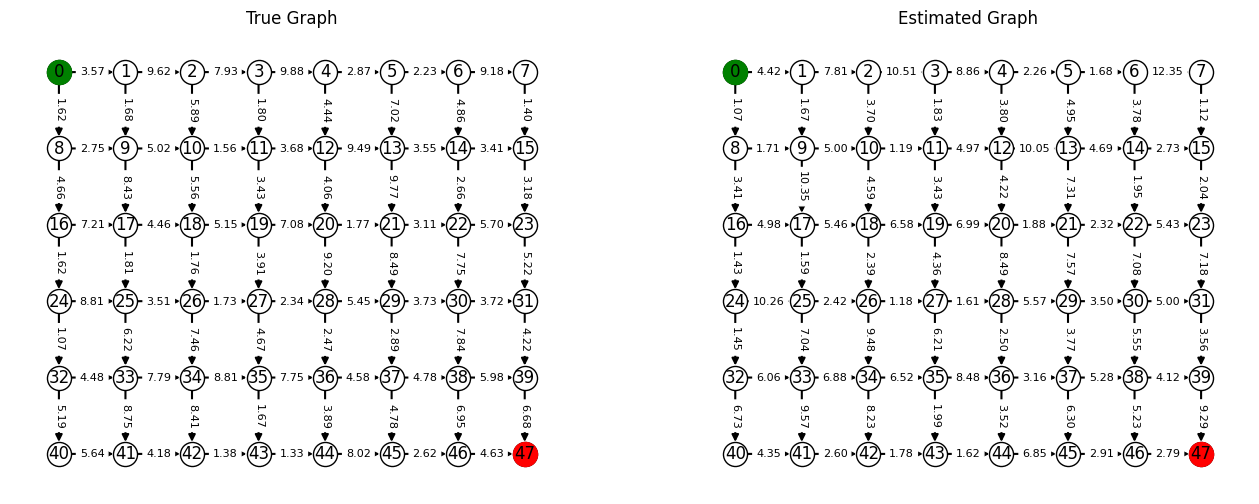

In [4]:
true_costs = np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * (c_max - c_min) + c_min
true_delays = np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * (d_max - d_min) + d_min
est_costs = np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * 2 * (1 - Q) * true_costs + Q * true_costs
est_delays = np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * 2 * (1 - Q) * true_delays + Q * true_delays

true_graph = ShortestPathGrid(network[0], network[1], true_costs)
est_graph = ShortestPathGrid(network[0], network[1], est_costs)

fig, ax = plt.subplots(1,2,figsize=(16, 6))
true_graph.visualize(ax=ax[0], title="True Graph")
est_graph.visualize(ax=ax[1], title="Estimated Graph")

In [5]:
# Solutions without information asymmetry
interdictor_I = BendersDecomposition(shortestPathGrb(true_graph), k=B, interdiction_cost=true_delays, max_cnt=20, eps=.1)
x_true_I, y_true_I, obj_true_I = interdictor_I.solve()

# Estimated shortest path after symmetric interdiction
est_shortest_path = shortestPathGrb(est_graph)
est_shortest_path.setObj(est_costs + x_true_I * est_delays)
y_est_I, obj_est_I = est_shortest_path.solve()

Restricted license - for non-production use only - expires 2026-11-23
Bender's decomposition running:
-------------------------------
Iteration 1: z_max = 81.14981105823776, z_min = 39.698079228401184
Iteration 2: z_max = 64.91745248777308, z_min = 46.706130623817444
Iteration 3: z_max = 63.49552443584305, z_min = 47.57986235618591
Iteration 4: z_max = 60.743701295952384, z_min = 51.39650106430054
Iteration 5: z_max = 60.74370129595248, z_min = 57.35854363441467
Iteration 6: z_max = 60.74370129595247, z_min = 57.29416310787201
Iteration 7: z_max = 60.53619093702854, z_min = 58.466301679611206
Iteration 8: z_max = 60.27838352994261, z_min = 52.56062173843384
Iteration 9: z_max = 59.82647099748733, z_min = 52.97728252410889
Iteration 10: z_max = 58.46630229419939, z_min = 58.04163634777069
Iteration 11: z_max = 58.46630229419939, z_min = 58.466301679611206
-------------------------------
Found epsilon-optimal solution after 11 iterations with epsilon = 0.00


Objective (True shortest path): 	58.466301679611206
Objective (Estimated shortest path): 	62.38239240545985


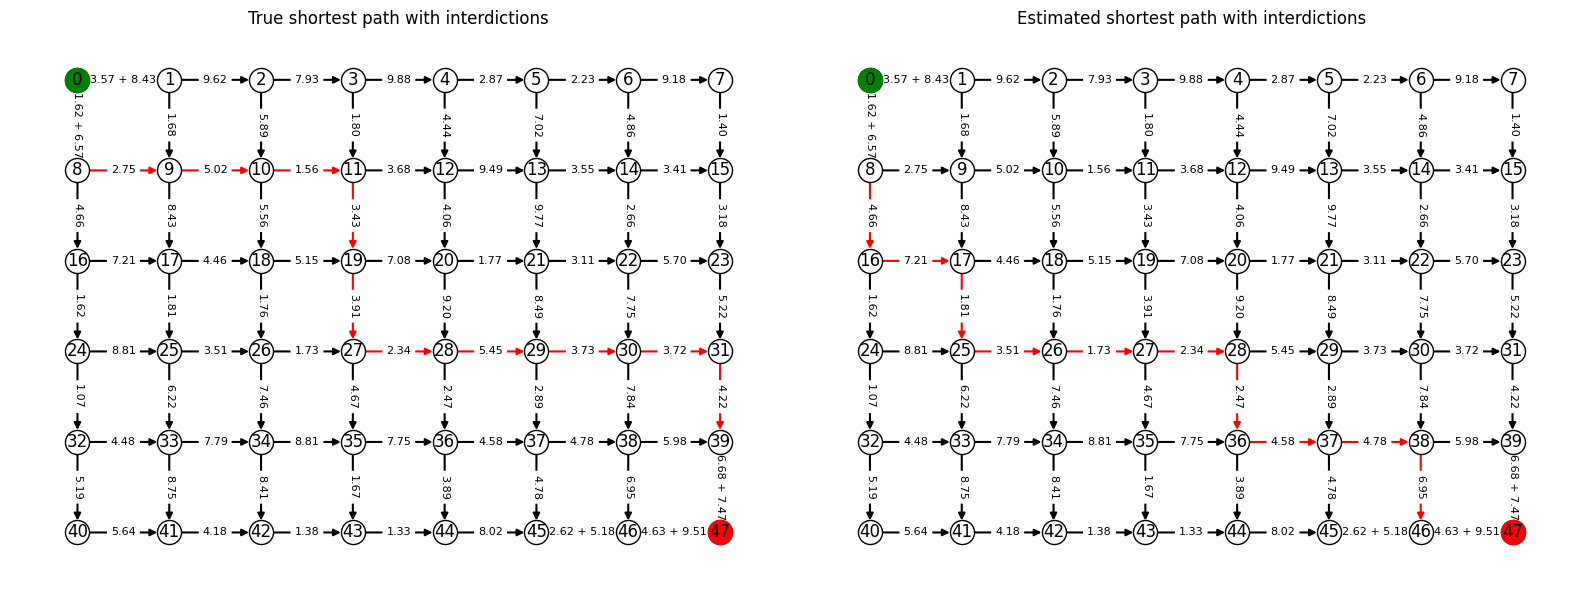

In [6]:
# Print results
print(f"Objective (True shortest path): \t{obj_true_I}")
print(f"Objective (Estimated shortest path): \t{true_graph(y_est_I, interdictions=x_true_I*true_delays)}")

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
true_graph.visualize(ax=ax[0], 
                     colored_edges=y_true_I, 
                     dashed_edges=x_true_I, 
                     interdictions=x_true_I*true_delays, 
                     title="True shortest path with interdictions")
true_graph.visualize(ax=ax[1], 
                   colored_edges=y_est_I, 
                   dashed_edges=x_true_I, 
                   interdictions=x_true_I*true_delays, 
                   title="Estimated shortest path with interdictions")
fig.tight_layout()

In [7]:
# Solution for interdictor with asymmetric information
est_costs = true_costs; est_delays = true_delays 
asym_interdictor = AsymmetricSPNI(true_graph, budget=B, true_costs=true_costs, true_delays=true_delays, est_costs=est_costs, est_delays=est_delays)
x_true_II, obj_true_II = asym_interdictor.solve()

# True shortest path after symmetric interdiction
true_shortest_path = shortestPathGrb(true_graph)
true_shortest_path.setObj(true_costs + x_true_II * true_delays)
y_true_II, obj_true_II = true_shortest_path.solve()

# Estimated shortest path after symmetric interdiction
est_shortest_path = shortestPathGrb(est_graph)
est_shortest_path.setObj(est_costs + x_true_II * est_delays)
y_est_II, obj_est_II = est_shortest_path.solve()


Objective (True shortest path): 	51.896814465522766
Objective (Estimated shortest path): 	51.89681460346331


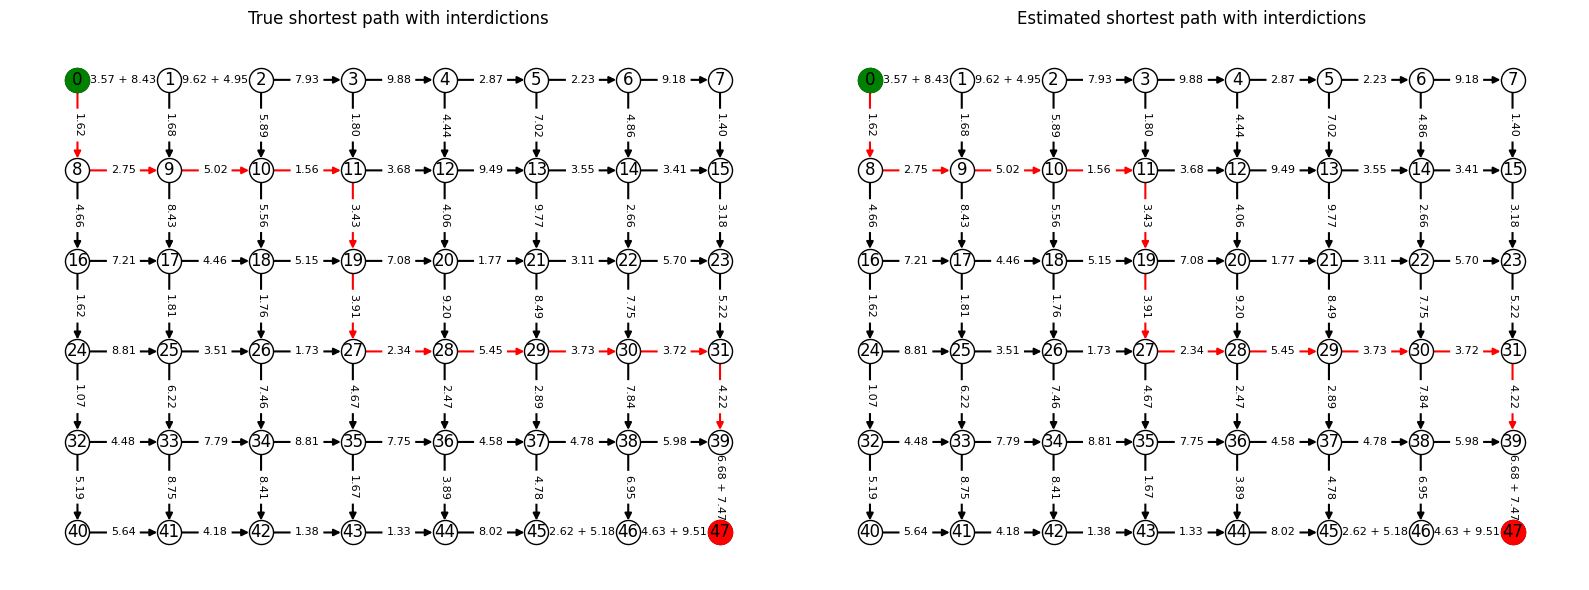

In [8]:
# Print results
print(f"Objective (True shortest path): \t{obj_true_II}")
print(f"Objective (Estimated shortest path): \t{true_graph(y_est_II, interdictions=x_true_II*true_delays)}")

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
true_graph.visualize(ax=ax[0], 
                     colored_edges=y_true_II, 
                     dashed_edges=x_true_II, 
                     interdictions=x_true_II*true_delays, 
                     title="True shortest path with interdictions")
true_graph.visualize(ax=ax[1], 
                   colored_edges=y_est_II, 
                   dashed_edges=x_true_II, 
                   interdictions=x_true_II*true_delays, 
                   title="Estimated shortest path with interdictions")
fig.tight_layout()

In [9]:
true_shortest_path = shortestPathGrb(true_graph)
path, obj = true_shortest_path.solve()
print(f"True shortest path objective: {obj}")

True shortest path objective: 39.698079228401184
